In [42]:
import torch
import numpy as np
import pandas as pd
import os
import math
import warnings
import itertools
import numbers
import torch.utils.data as utils
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [43]:
inputpath = './input/set-a/'
inputdict = {
    "ALP" : 0,             # o
    "ALT" : 1,             # o
    "AST" : 2,             # o
    "Albumin" : 3,         # o
    "BUN" : 4,             # o
    "Bilirubin" : 5,       # o
    "Cholesterol" : 6,     # o
    "Creatinine" : 7,      # o
    "DiasABP" : 8,         # o
    "FiO2" : 9,            # o
    "GCS" : 10,            # o
    "Glucose" : 11,        # o
    "HCO3" : 12,           # o
    "HCT" : 13,            # o
    "HR" : 14,             # o
    "K" : 15,              # o
    "Lactate" : 16,        # o
    "MAP" : 17,            # o
    "Mg" : 18,             # o
    "Na" : 19,             # o
    "PaCO2" : 20,          # o
    "PaO2" : 21,           # o
    "Platelets" : 22,      # o
    "RespRate" : 23,       # o
    "SaO2" : 24,           # o
    "SysABP" : 25,         # o
    "Temp" : 26,           # o
    "Tropl" : 27,          # o
    "TroponinI" : 27,      # temp: regarded same as Tropl
    "TropT" : 28,          # o
    "TroponinT" : 28,      # temp: regarded same as TropT
    "Urine" : 29,          # o
    "WBC" : 30,            # o
    "Weight" : 31,         # o
    "pH" : 32,             # o
    "NIDiasABP" : 33,      # unused variable
    "NIMAP" : 34,          # unused variable
    "NISysABP" : 35,       # unused variable
    "MechVent" : 36,       # unused variable
    "RecordID" : 37,       # unused variable
    "Age" : 38,            # unused variable
    "Gender" :39,          # unused variable
    "ICUType" : 40,        # unused variable
    "Height": 41           # unused variable
}

In [44]:
# functions to process the time in the data
def timeparser(time):
    return pd.to_timedelta(time + ':00')

def timedelta_to_day_figure(timedelta):
    return timedelta.days + (timedelta.seconds/86400) #(24*60*60)

In [45]:
# group the data by time
def df_to_inputs(df, inputdict, inputs):
    grouped_data = df.groupby('Time')
            
    for row_index, value in df.iterrows():
        '''
        t = colum ~ time frame
        agg_no = row ~ variable
        '''
        
        agg_no = inputdict[value.Parameter]

        #print('agg_no : {}\t  value : {}'.format(agg_no, value.Value))
        inputs[agg_no].append(value.Value)    
        
    return inputs

In [46]:
inputs = []

# prepare empty list to put data
# len(inputdict)-2: two items has same agg_no
for i in range(len(inputdict)-2):
    t = []
    inputs.append(t)

# read all the files in the input folder
for filename in os.listdir(inputpath):
    df = pd.read_csv(inputpath + filename, header=0, \
                     parse_dates=['Time'], date_format=timeparser)
    
    inputs = df_to_inputs(df=df, inputdict=inputdict, inputs=inputs)

print(inputs[0][0])


46.0


In [58]:
print(len(inputs))

42


In [59]:
# Create an object array to store the list of arrays
object_inputs = np.empty(len(inputs), dtype=object)
for i in range(len(inputs)):
    object_inputs[i] = inputs[i]

# Save and load using np.save and np.load with allow_pickle=True
np.save('./input/inputs', object_inputs)
loaded_inputs = np.load('./input/inputs.npy', allow_pickle=True)
print(loaded_inputs[0][0])

46.0


In [60]:
# make input items list
input_columns = list(inputdict.keys())

'''
remove two overlaped items
"TroponinI" : 27, #temp
"TroponinT" : 28, #temp

'''
input_columns.remove("TroponinI")
input_columns.remove("TroponinT")
print(input_columns)
print(len(input_columns))

['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Bilirubin', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'K', 'Lactate', 'MAP', 'Mg', 'Na', 'PaCO2', 'PaO2', 'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'Tropl', 'TropT', 'Urine', 'WBC', 'Weight', 'pH', 'NIDiasABP', 'NIMAP', 'NISysABP', 'MechVent', 'RecordID', 'Age', 'Gender', 'ICUType', 'Height']
42


In [61]:
# describe the data
# print count, min, max, mean, median, std, var and histogram if hist == True
# return values as a list
def describe(inputs, input_columns, inputdict, hist = False):
    
    desc = [] 
    
    for i in range(len(inputdict)-2):
        input_arr = np.asarray(inputs[i])
        
        des = []
        
        des.append(input_arr.size)
        des.append(np.amin(input_arr))
        des.append(np.amax(input_arr))
        des.append(np.mean(input_arr))
        des.append(np.median(input_arr))
        des.append(np.std(input_arr))
        des.append(np.var(input_arr))
        
        desc.append(des)
        
        # print histgram
        if hist:
            a = np.hstack(input_arr)
            plt.hist(a, bins='auto')
            plt.title("Histogram about {}".format(input_columns[i]))
            plt.show()
        
        print('count: {}, min: {}, max: {}'.format(des[0], des[1], des[2]))
        print('mean: {}, median: {}, std: {}, var: {}'.format(des[3], des[4], des[5], des[6]))
    
    return desc       

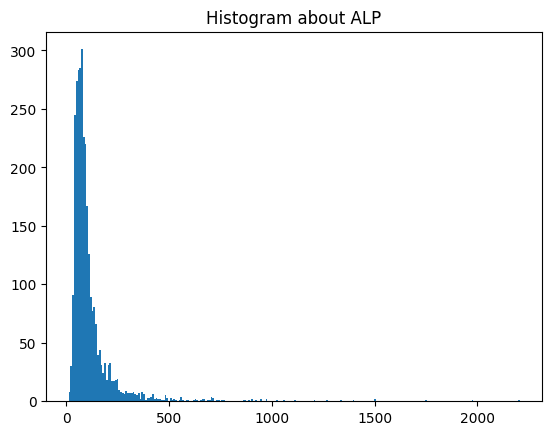

count: 3092, min: 12.0, max: 2205.0
mean: 116.77328589909443, median: 82.0, std: 133.88381709195593, var: 17924.87647911231


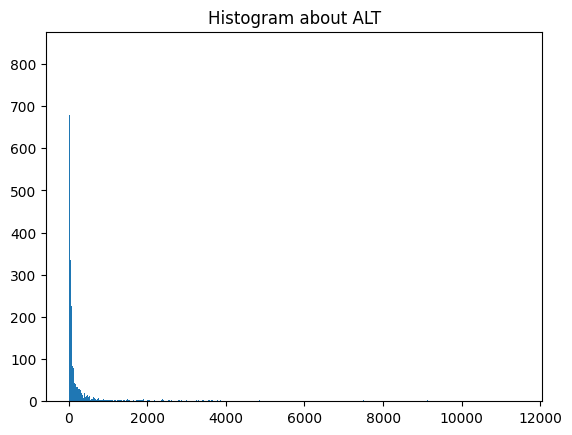

count: 3177, min: 1.0, max: 11470.0
mean: 394.4749763928234, median: 43.0, std: 1199.980190826508, var: 1439952.4583760228


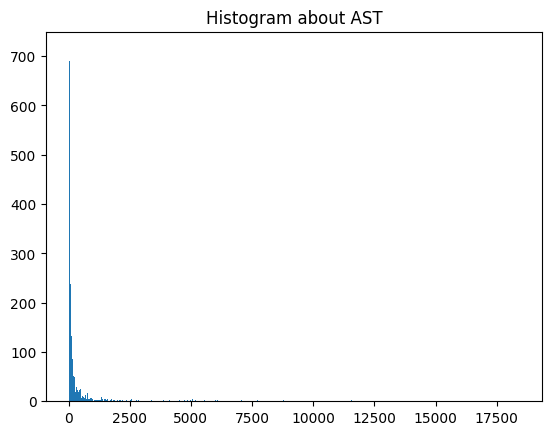

count: 3182, min: 4.0, max: 18430.0
mean: 506.2840980515399, median: 64.0, std: 1516.1916042785547, var: 2298836.9808847774


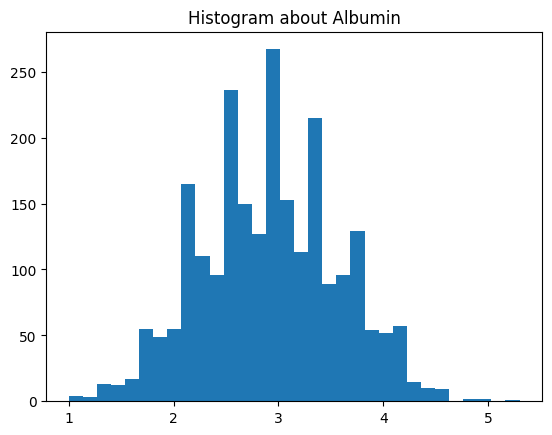

count: 2356, min: 1.0, max: 5.3
mean: 2.9223259762309, median: 2.9, std: 0.6514075310421351, var: 0.4243317714984103


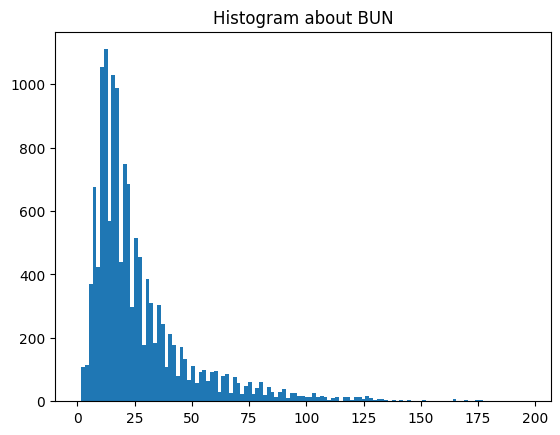

count: 13916, min: 0.0, max: 197.0
mean: 27.416527737855706, median: 20.0, std: 23.393032927627267, var: 547.2339895530536


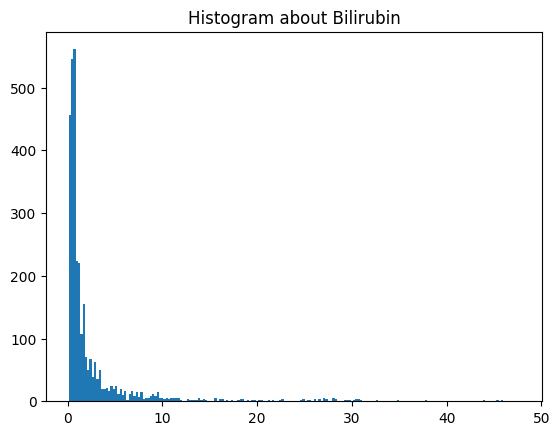

count: 3191, min: 0.1, max: 47.7
mean: 2.9085553118144785, median: 0.9, std: 5.903983019417633, var: 34.85701549357175


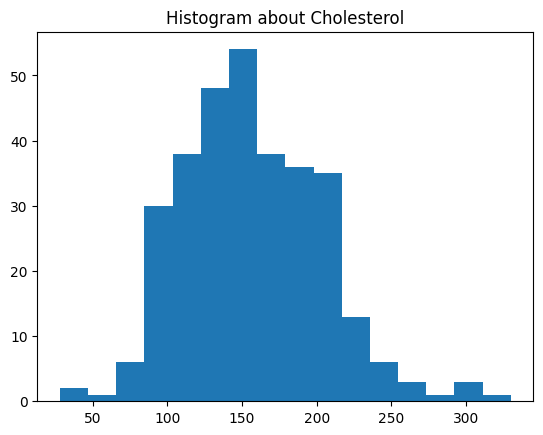

count: 315, min: 28.0, max: 330.0
mean: 156.51746031746032, median: 152.0, std: 45.99491531484598, var: 2115.532234819854


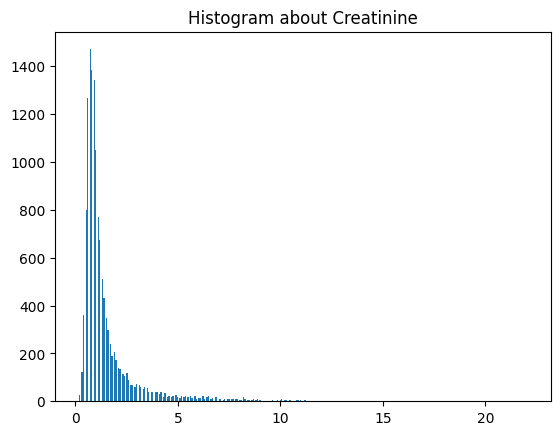

count: 13983, min: 0.1, max: 22.1
mean: 1.5049774726453549, median: 1.0, std: 1.635940329877449, var: 2.676300762919537


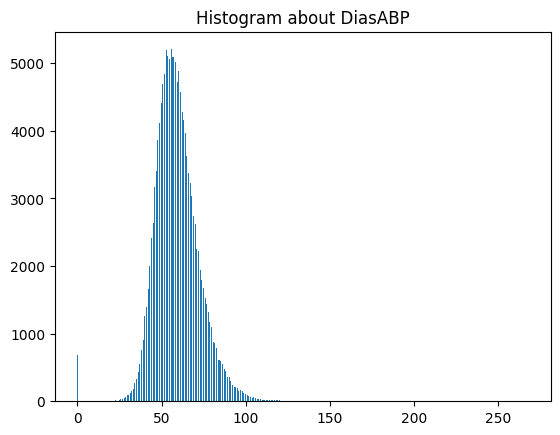

count: 145567, min: 0.0, max: 268.0
mean: 59.29051227269917, median: 58.0, std: 13.318150168032814, var: 177.37312389827244


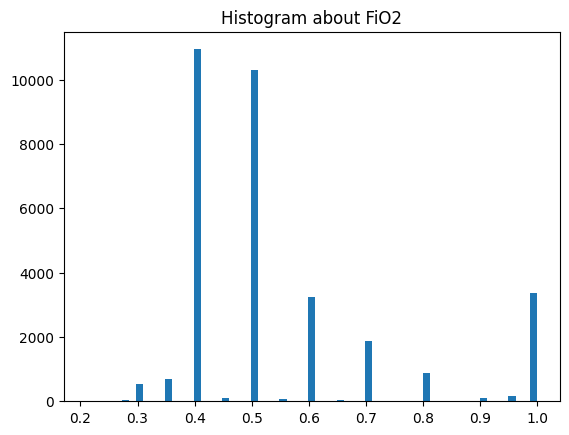

count: 32390, min: 0.21, max: 1.0
mean: 0.5452014510651436, median: 0.5, std: 0.18984649512536758, var: 0.03604169171138622


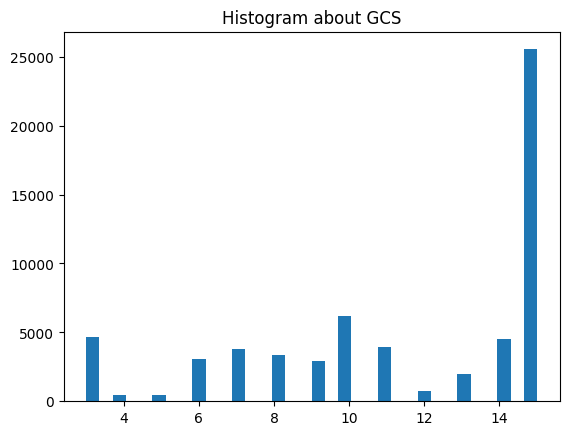

count: 61563, min: 3.0, max: 15.0
mean: 11.398713512986697, median: 13.0, std: 3.973384107597854, var: 15.787781266511194


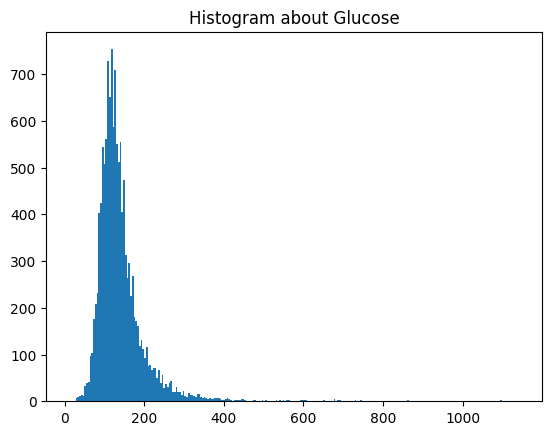

count: 13021, min: 10.0, max: 1143.0
mean: 141.5095614776131, median: 127.0, std: 67.69497269352856, var: 4582.609327977577


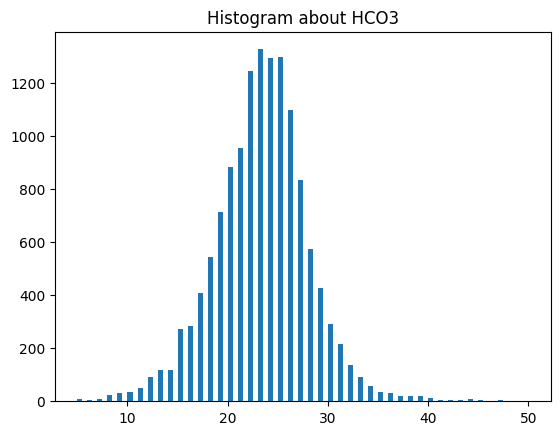

count: 13613, min: 5.0, max: 50.0
mean: 23.11574230514949, median: 23.0, std: 4.710165655553443, var: 22.185660502755194


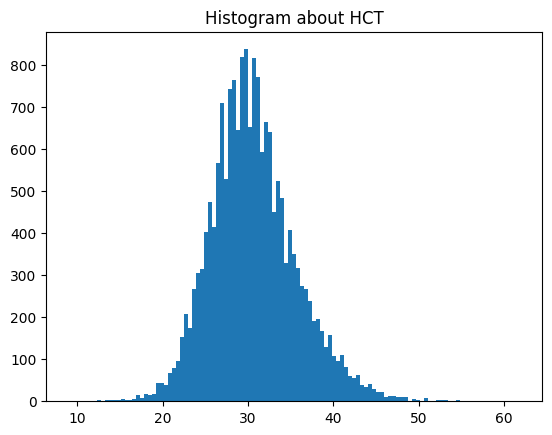

count: 18271, min: 9.0, max: 61.8
mean: 30.679043292649556, median: 30.3, std: 5.013220252647734, var: 25.132377301557415


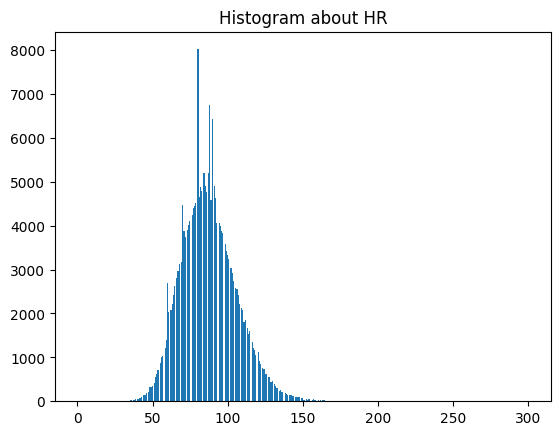

count: 228538, min: 0.0, max: 300.0
mean: 87.51744217591822, median: 86.0, std: 18.4049963443074, var: 338.7438904339688


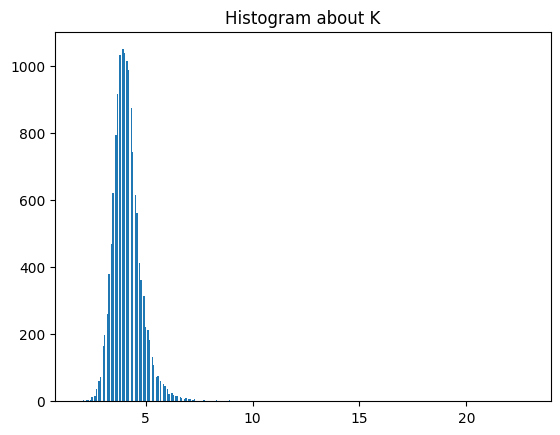

count: 14440, min: 1.8, max: 22.9
mean: 4.136218836565097, median: 4.1, std: 0.7070606291358561, var: 0.4999347332739927


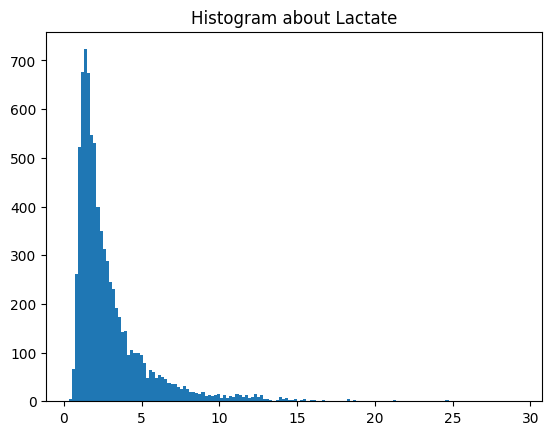

count: 8024, min: 0.3, max: 29.3
mean: 2.924779411764706, median: 2.1, std: 2.579141072175832, var: 6.6519686701843


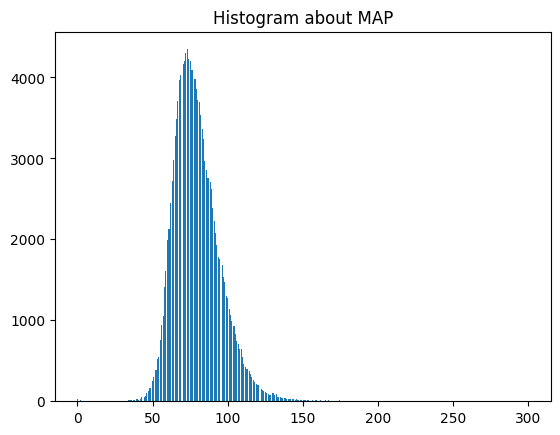

count: 145760, min: 0.0, max: 300.0
mean: 79.74292672886938, median: 77.0, std: 16.926822834796283, var: 286.51733128058083


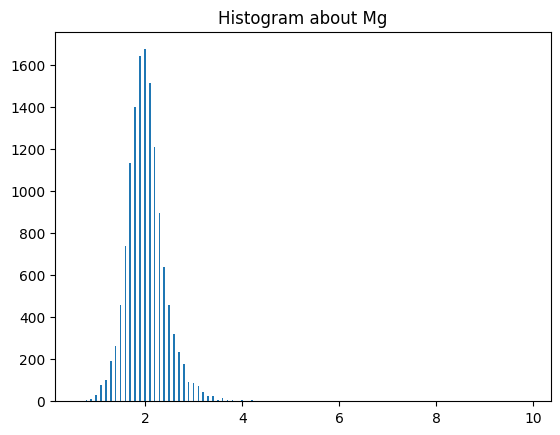

count: 13590, min: 0.6, max: 9.9
mean: 2.0279102281089036, median: 2.0, std: 0.4221239657011912, var: 0.17818864241930044


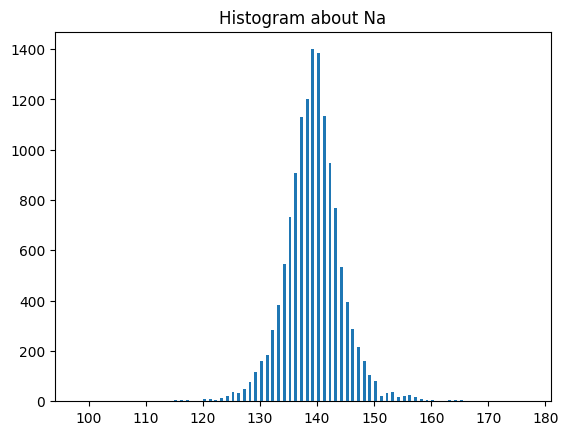

count: 13570, min: 98.0, max: 177.0
mean: 139.07582903463523, median: 139.0, std: 5.19109386912776, var: 26.947455558095825


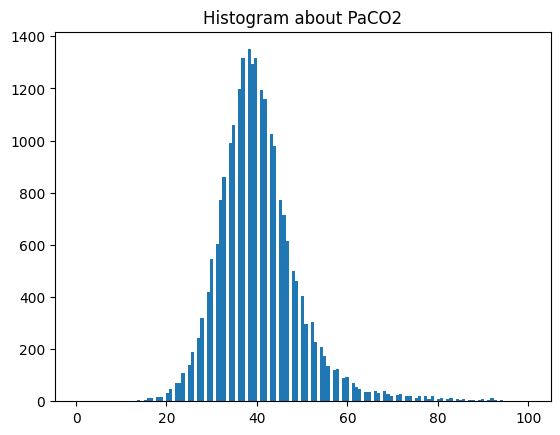

count: 23293, min: 0.3, max: 100.0
mean: 40.47474777830249, median: 39.0, std: 9.126020846980067, var: 83.28425649951477


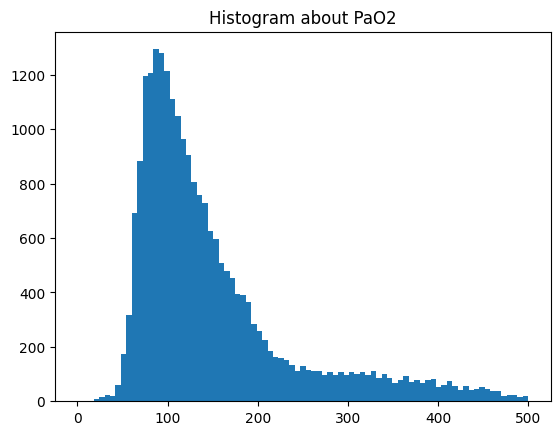

count: 23268, min: 0.0, max: 500.0
mean: 150.41526860924876, median: 121.0, std: 89.29887429104858, var: 7974.288949648496


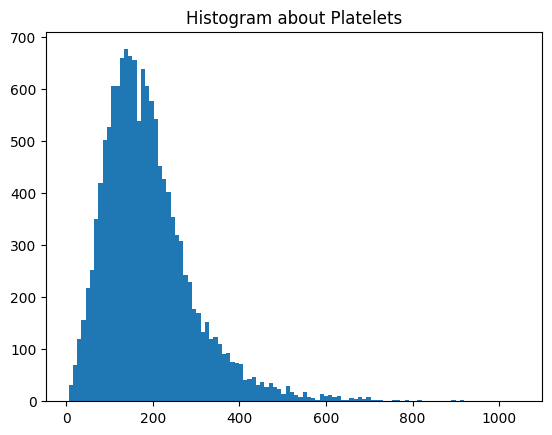

count: 14104, min: 6.0, max: 1047.0
mean: 190.81571894498015, median: 172.0, std: 106.39173621423238, var: 11319.201534678805


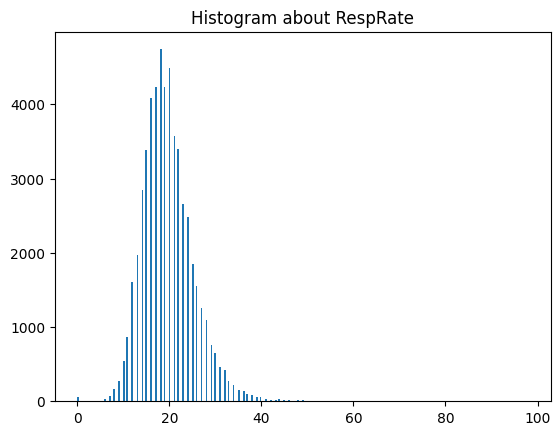

count: 55051, min: 0.0, max: 98.0
mean: 19.723728905923597, median: 19.0, std: 5.552301672088858, var: 30.82805385788073


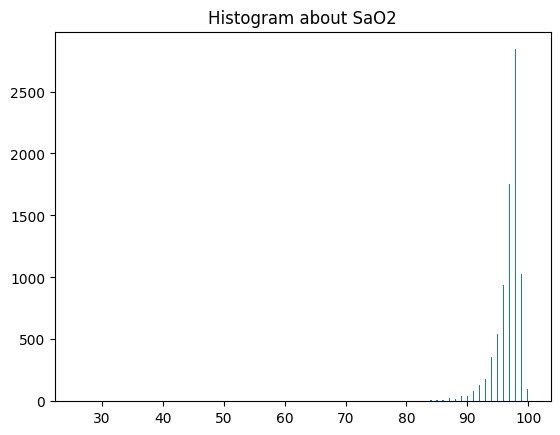

count: 8185, min: 26.0, max: 100.0
mean: 96.63706780696396, median: 97.0, std: 3.4000868440410503, var: 11.56059054702103


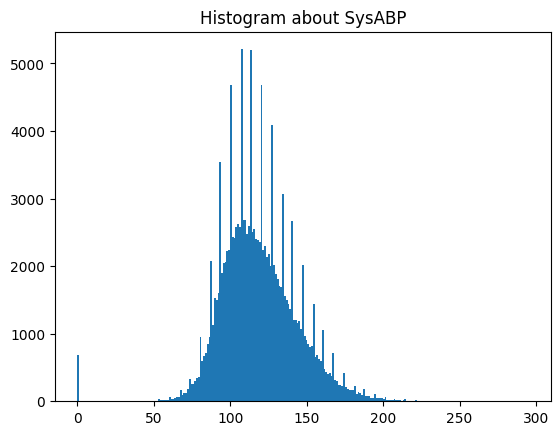

count: 145650, min: 0.0, max: 295.0
mean: 118.6978990731205, median: 116.0, std: 25.01615547443329, var: 625.8080347210188


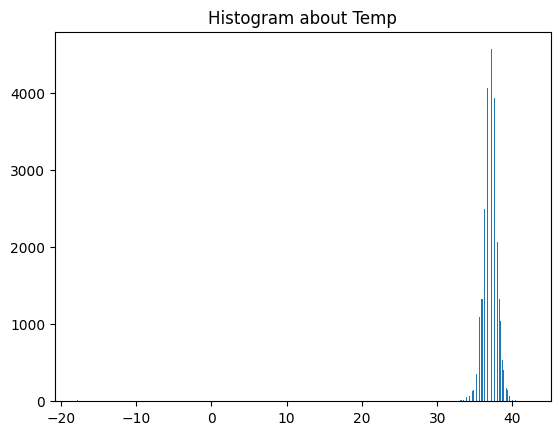

count: 86405, min: -17.8, max: 42.1
mean: 37.00765117759389, median: 37.1, std: 1.7751633850901565, var: 3.151205043764743


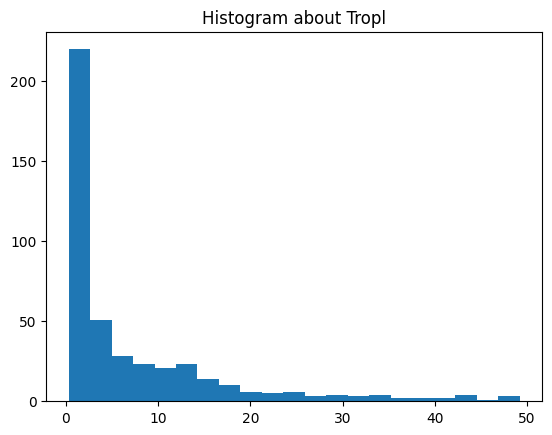

count: 435, min: 0.3, max: 49.2
mean: 7.1512643678160925, median: 2.6, std: 9.75616596124948, var: 95.182774263443


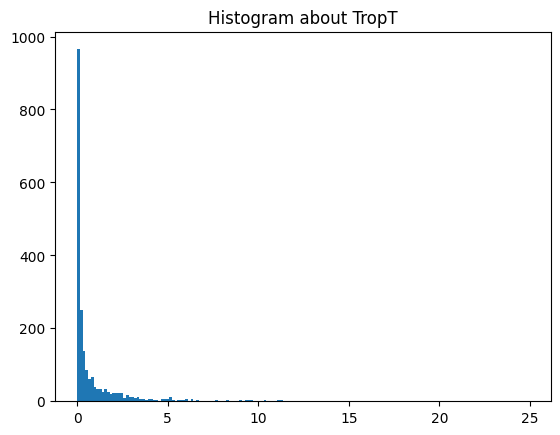

count: 2126, min: 0.01, max: 24.91
mean: 1.1984510818438383, median: 0.2, std: 2.7137681474380155, var: 7.364537558049158


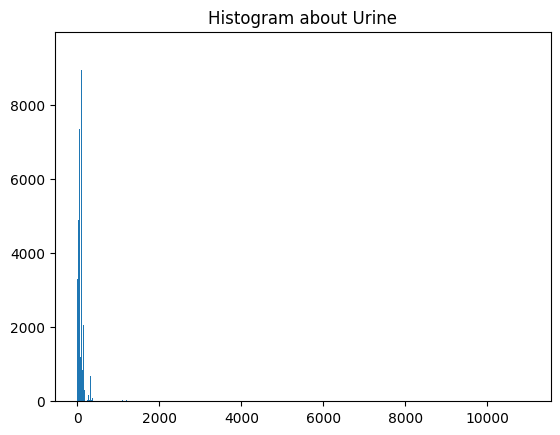

count: 136918, min: 0.0, max: 11000.0
mean: 120.7987284359982, median: 70.0, std: 184.72583948660204, var: 34123.63577402986


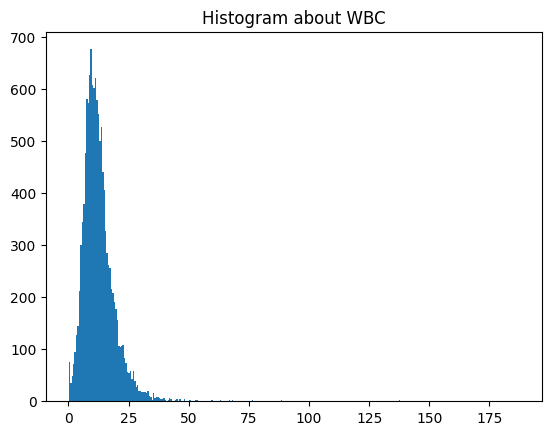

count: 12910, min: 0.1, max: 187.5
mean: 12.670084430673898, median: 11.4, std: 7.6412549541321315, var: 58.38877727404884


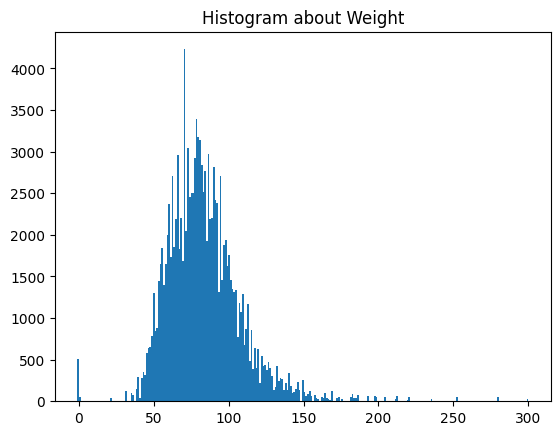

count: 129165, min: -1.0, max: 300.0
mean: 83.38661525955172, median: 80.6, std: 25.047736295633513, var: 627.3890935355964


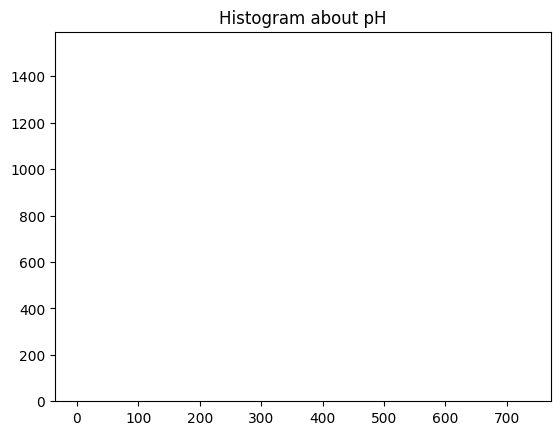

count: 24355, min: 1.0, max: 735.0
mean: 7.489199753644017, median: 7.38, std: 8.243936500293188, var: 67.9624890208663


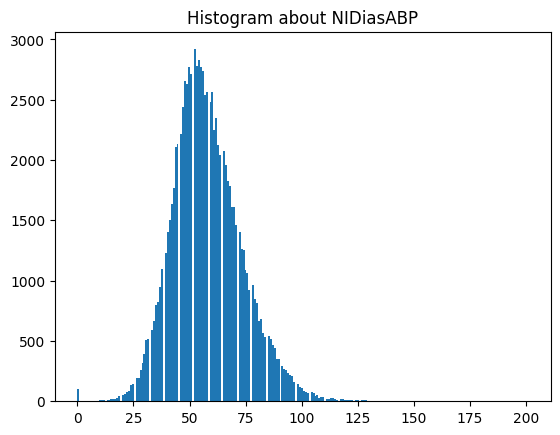

count: 98210, min: 0.0, max: 201.0
mean: 57.95386416861827, median: 56.0, std: 15.547704216052558, var: 241.73110638985852


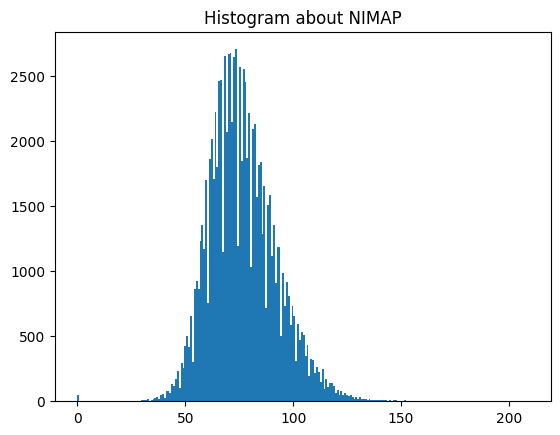

count: 96871, min: 0.0, max: 209.0
mean: 76.78045028956035, median: 75.0, std: 15.636321918012722, var: 244.49456312372507


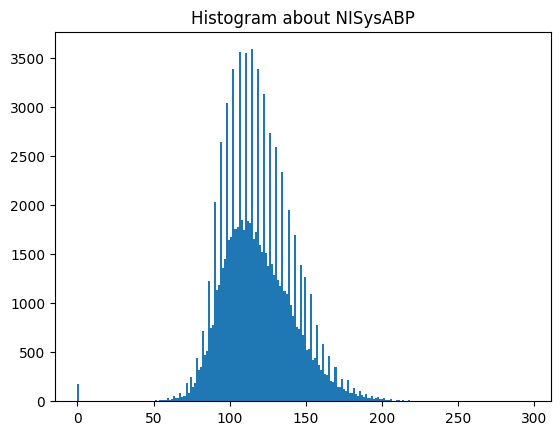

count: 98331, min: 0.0, max: 296.0
mean: 118.59402426498256, median: 116.0, std: 23.260108542419854, var: 541.032649405153


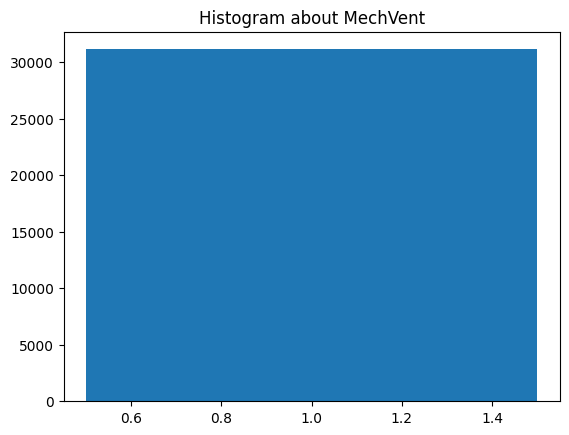

count: 31144, min: 1.0, max: 1.0
mean: 1.0, median: 1.0, std: 0.0, var: 0.0


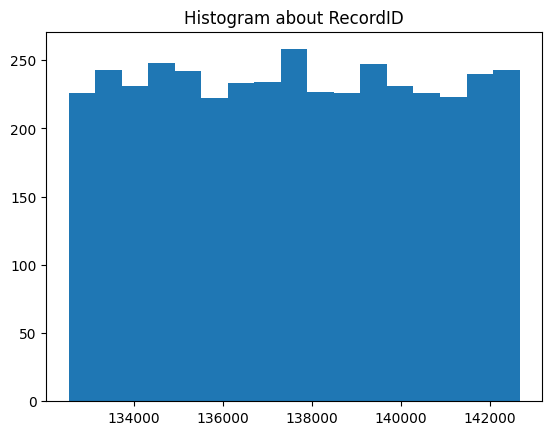

count: 4000, min: 132539.0, max: 142673.0
mean: 137605.122, median: 137592.5, std: 2923.2434123958956, var: 8545352.048116


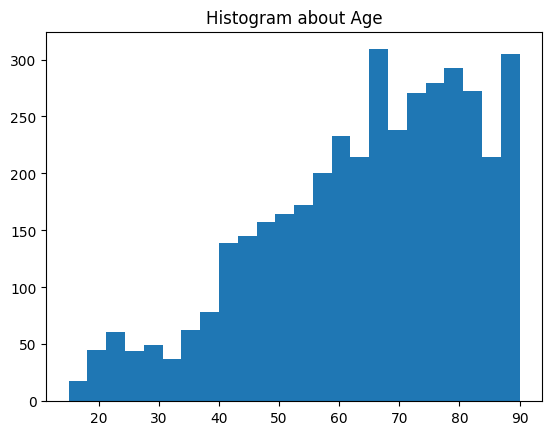

count: 4000, min: 15.0, max: 90.0
mean: 64.2475, median: 67.0, std: 17.558751201324085, var: 308.30974375


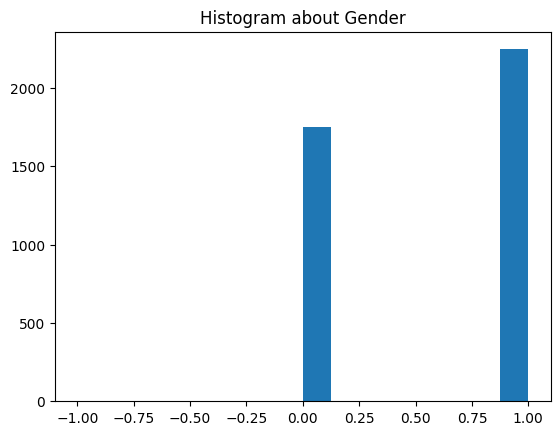

count: 4000, min: -1.0, max: 1.0
mean: 0.56075, median: 1.0, std: 0.49780461779698265, var: 0.24780943749999998


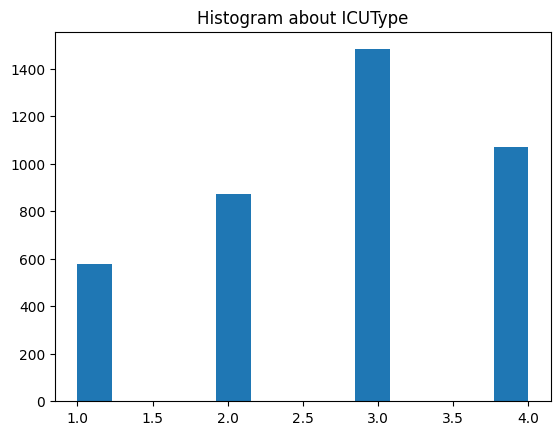

count: 4000, min: 1.0, max: 4.0
mean: 2.76, median: 3.0, std: 1.002447006080621, var: 1.0049000000000003


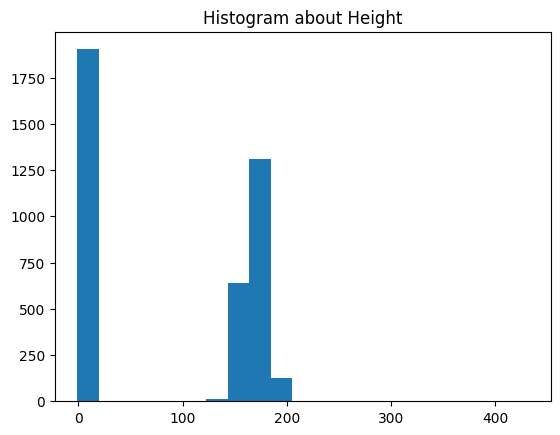

count: 4000, min: -1.0, max: 431.8
mean: 88.919475, median: 152.4, std: 86.52038637352688, var: 7485.777258224374


(42, 7)

In [62]:
desc = describe(loaded_inputs, input_columns, inputdict, hist=True)
desc = np.asarray(desc)
desc.shape

In [66]:
# save desc
# 0: count, 1: min, 2: max, 3: mean, 4: median, 5: std, 6: var
np.save('./input/desc', desc)
loaded_desc = np.load('./input/desc.npy')

In [67]:
def normalization(desc, inputs):
    # for each catagory
    for i in range(desc.shape[0]):
        # for each value
        for j in range(len(inputs[i])):
            inputs[i][j] = (inputs[i][j] - desc[i][3])/desc[i][5]
    return inputs

In [68]:
'''
dataframe to dataset
'''

def df_to_x_m_d(df, inputdict, size, id_posistion, split):
    grouped_data = df.groupby('Time')
    
    #generate input vectors
    x = np.zeros((len(inputdict)-2, grouped_data.ngroups))
    masking = np.zeros((len(inputdict)-2, grouped_data.ngroups))
    delta = np.zeros((split, size))
    timetable = np.zeros(grouped_data.ngroups)
    id = 0
    
    all_x = np.zeros((split,1))
    
    s_dataset = np.zeros((3, split, size))
   
    if grouped_data.ngroups > size:
        
        # fill the x and masking vectors
        pre_time = pd.to_timedelta(0)
        t = 0
        for row_index, value in df.iterrows():
            '''
            t = colum, time frame
            agg_no = row, variable
            '''
            #print(value)
            agg_no = inputdict[value.Parameter]

            # same timeline check.        
            if pre_time != value.Time:
                pre_time = value.Time
                t += 1
                timetable[t] = timedelta_to_day_figure(value.Time)

            #print('agg_no : {}\t t : {}\t value : {}'.format(agg_no, t, value.Value))
            x[agg_no, t] = value.Value    
            masking[agg_no, t] = 1
        
        '''
        # generate random index array 
        ran_index = np.random.choice(grouped_data.ngroups, size=size, replace=False)
        ran_index.sort()
        ran_index[0] = 0
        ran_index[size-1] = grouped_data.ngroups-1
        '''
        
        # generate index that has most parameters and first/last one.
        ran_index = grouped_data.count()
        ran_index = ran_index.reset_index()
        ran_index = ran_index.sort_values('Value', ascending=False)
        ran_index = ran_index[:size]
        ran_index = ran_index.sort_index()
        ran_index = np.asarray(ran_index.index.values)
        ran_index[0] = 0
        ran_index[size-1] = grouped_data.ngroups-1
        
        #print(ran_index)
        
        # take id for outcome comparing
        id = x[id_posistion, 0]
        
        # remove unnesserly parts(rows)
        x = x[:split, :]
        masking = masking[:split, :]
        
        # coulme(time) sampling
        x_sample = np.zeros((split, size))
        m_sample = np.zeros((split, size))
        time_sample = np.zeros(size)

        t_x_sample = x_sample.T
        t_marsking = m_sample.T
        #t_time = t_sample.T
        
        t_x = x.T
        t_m = masking.T
        #t_t = t.T

        it = np.nditer(ran_index, flags=['f_index'])
        while not it.finished:
            #print('it.index = {}, it[0] = {}, ran_index = {}'.format(it.index, it[0], ran_index[it.index]))
            t_x_sample[it.index] = t_x[it[0]]
            t_marsking[it.index] = t_m[it[0]]
            time_sample[it.index] = timetable[it[0]]
            it.iternext()
        
        x = x_sample
        masking = m_sample
        timetable = time_sample
        '''
        # normalize the X
        nor_x = x/max_input[:, np.newaxis]
        '''
        # fill the delta vectors
        for index, value in np.ndenumerate(masking):
            '''
            index[0] = row, agg
            index[1] = col, time
            '''
            if index[1] == 0:
                delta[index[0], index[1]] = 0
            elif masking[index[0], index[1]-1] == 0:
                delta[index[0], index[1]] = timetable[index[1]] - timetable[index[1]-1] + delta[index[0], index[1]-1]
            else:
                delta[index[0], index[1]] = timetable[index[1]] - timetable[index[1]-1]
    
    else:
                
        # fill the x and masking vectors
        pre_time = pd.to_timedelta(0)
        t = 0
        for row_index, value in df.iterrows():
            '''
            t = colum, time frame
            agg_no = row, variable
            '''
            #print(value)
            agg_no = inputdict[value.Parameter]

            # same timeline check.        
            if pre_time != value.Time:
                pre_time = value.Time
                t += 1
                timetable[t] = timedelta_to_day_figure(value.Time)

            #print('agg_no : {}\t t : {}\t value : {}'.format(agg_no, t, value.Value))
            x[agg_no, t] = value.Value    
            masking[agg_no, t] = 1
        
        # take id for outcome comparing
        id = x[id_posistion, 0]
        
        # remove unnesserly parts(rows)
        x = x[:split, :]
        masking = masking[:split, :]
        
        x = np.pad(x, ((0,0), (size-grouped_data.ngroups, 0)), 'constant')
        masking = np.pad(masking, ((0,0), (size-grouped_data.ngroups, 0)), 'constant')
        timetable = np.pad(timetable, (size-grouped_data.ngroups, 0), 'constant')
        '''
        # normalize the X
        nor_x = x/max_input[:, np.newaxis]
        '''
        # fill the delta vectors
        for index, value in np.ndenumerate(masking):
            '''
            index[0] = row, agg
            index[1] = col, time
            '''
            if index[1] == 0:
                delta[index[0], index[1]] = 0
            elif masking[index[0], index[1]-1] == 0:
                delta[index[0], index[1]] = timetable[index[1]] - timetable[index[1]-1] + delta[index[0], index[1]-1]
            else:
                delta[index[0], index[1]] = timetable[index[1]] - timetable[index[1]-1]
    

    all_x = np.concatenate((all_x, x), axis=1)
    all_x = all_x[:,1:]
    
    s_dataset[0] = x
    s_dataset[1] = masking
    s_dataset[2] = delta
    
    return s_dataset, all_x, id

In [69]:
# def df_to_x_m_d(df, inputdict, mean, std, size, id_posistion, split):
size = 49 # steps ~ from the paper
id_posistion = 37
input_length = 33 # input variables ~ from the paper
dataset = np.zeros((1,3, input_length, size))

all_x_add = np.zeros((input_length,1))

for filename in os.listdir(inputpath):
    df = pd.read_csv(inputpath + filename,\
                     header=0,\
                     parse_dates=['Time'],\
                     date_parser=timeparser)
    s_dataset, all_x, id = df_to_x_m_d(df=df, inputdict=inputdict, size=size, id_posistion=id_posistion, split=input_length)
    
    dataset = np.concatenate((dataset, s_dataset[np.newaxis, :,:,:]))
    all_x_add = np.concatenate((all_x_add, all_x), axis=1)
    

dataset = dataset[1:, :,:,:]    
# (total datasets, kind of data(x, masking, and delta), input length, num of varience)
# (4000, 3, 33, 49)
print(dataset.shape)
print(dataset[0].shape)
print(dataset[0][0][0])

print(all_x_add.shape)
all_x_add = all_x_add[:, 1:]
print(all_x_add.shape)

/tmp/ipykernel_594/1583530010.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(inputpath + filename,\
/tmp/ipykernel_594/1583530010.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(inputpath + filename,\
/tmp/ipykernel_594/1583530010.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(inputpath + filename,\
/tmp/ipykernel_594/1583530010.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead

(4000, 3, 33, 49)
(3, 33, 49)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
(33, 196001)
(33, 196000)


/tmp/ipykernel_594/1583530010.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(inputpath + filename,\
/tmp/ipykernel_594/1583530010.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(inputpath + filename,\


In [24]:
train_proportion = 0.8
train_index = int(all_x_add.shape[1] * train_proportion)
train_x = all_x_add[:, :train_index]
train_x.shape

(33, 156800)

In [25]:
def get_mean(x):
    x_mean = []
    for i in range(x.shape[0]):
        mean = np.mean(x[i])
        x_mean.append(mean)
    return x_mean

In [26]:
def get_median(x):
    x_median = []
    for i in range(x.shape[0]):
        median = np.median(x[i])
        x_median.append(median)
    return x_median

In [27]:
def get_std(x):
    x_std = []
    for i in range(x.shape[0]):
        std = np.std(x[i])
        x_std.append(std)
    return x_std

In [28]:
def get_var(x):
    x_var = []
    for i in range(x.shape[0]):
        var = np.var(x[i])
        x_var.append(var)
    return x_var

In [29]:
x_mean = get_mean(train_x)
print(x_mean)
print(len(x_mean))

[1.7823724489795918, 6.54876275510204, 8.242704081632652, 0.03297193877551021, 1.8340688775510203, 0.045324617346938774, 0.2327359693877551, 0.10116645408163263, 31.66253826530612, 0.06175065688775509, 3.4176466836734694, 8.964923469387756, 1.5530076530612245, 2.025498724489796, 76.80652359693877, 0.2739917091836735, 0.00852110969387755, 42.47453443877551, 0.12422576530612243, 9.207525510204082, 0.45053125, 1.5804336734693878, 11.84391581632653, 4.645229591836735, 0.6585204081632653, 63.5312181122449, 13.681771045918369, 0.010373086734693877, 0.010481230867346938, 73.19175573979592, 0.7418538903061223, 44.534804272959185, 0.08916677295918368]
33


In [30]:
x_std = get_std(train_x)
print(x_std)
print(len(x_std))

[21.346502616665866, 160.8762272831097, 194.35446383498862, 0.3159133490540197, 8.97754383967102, 0.7907032054850887, 6.261895702986738, 0.5634893603989649, 31.13958652855645, 0.18251521610512406, 5.6625428387499, 38.04330634148538, 5.923950426708912, 7.799891225611797, 32.56802628465359, 1.0417146554602417, 0.18525150031283508, 41.805030663188006, 0.4951165602297099, 34.6029329150851, 4.415600298179585, 17.14729510458615, 54.20288123482163, 8.758024320490781, 7.963874035137843, 61.97330529184976, 17.90848917352305, 0.4524626363987425, 0.29062240339812645, 138.15366891766675, 3.5560652894829174, 45.65572121944366, 2.0377819838032987]
33


In [31]:
# dataset shape : (4000, 3, 33, 49)
def dataset_normalize(dataset, mean, std):
    for i in range(dataset.shape[0]):        
        dataset[i][0] = (dataset[i][0] - mean[:, None])
        dataset[i][0] = dataset[i][0]/std[:, None]
        
    return dataset

In [32]:
x_mean = np.asarray(x_mean)
x_std = np.asarray(x_std)

In [33]:
dataset = dataset_normalize(dataset=dataset, mean=x_mean, std=x_std)
print(dataset[0][0][0])

[-0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716
 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716
 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716
 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716
 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716
 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716
 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716
 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716 -0.08349716
 -0.08349716]


In [34]:
def normalize_chk(dataset):
    all_x_add = np.zeros((dataset[0][0].shape[0],1))
    for i in range(dataset.shape[0]):
        all_x_add = np.concatenate((all_x_add, dataset[i][0]), axis=1)
    
    mean = get_mean(all_x_add)
    median = get_median(all_x_add)
    std = get_std(all_x_add)
    var = get_var(all_x_add)
    
    print('mean')
    print(mean)
    print('median')
    print(median)
    print('std')
    print(std)
    print('var')
    print(var)
    
    return mean, median, std, var

In [35]:
nor_mean, nor_median, nor_std, nor_var = normalize_chk(dataset)

mean
[-0.0003128633047919913, -0.0035456631205851826, -0.002675720190878244, 0.0015536343236148542, 0.0035865383322782043, 0.0009741666366323543, 0.00033711174980943114, 0.0020523887100829434, 0.004224455520784825, 0.0018168437216244308, -9.888598438361923e-05, 0.0022983893306068614, -3.8670219595713914e-05, 0.00025435206620329914, -0.0009621452490073763, 0.0011564714338464757, 0.0018885564127546336, 0.0038933268699569198, 0.0017574621646406533, 0.0005251975811138602, 0.002103125087268134, 0.0021762112283343384, -0.0013172758401586767, 0.000716540392752051, 0.0013869960727872549, 0.004091129189692759, -0.0002915387909011885, 0.002513161206856324, -0.0005520187932777708, 0.002530339169845264, -0.002775586406676316, -0.007077454680256008, 0.003968211081220385]
median
[-0.08349716489801187, -0.04070683944855034, -0.042410675417421315, -0.1043701979490337, -0.20429517363606986, -0.057321909197437196, -0.03716701465927434, -0.17953569524365853, 0.36408517255991496, -0.3383315550643641, -0.6

In [36]:
np.save('./input/x_mean_aft_nor', nor_mean)
np.save('./input/x_median_aft_nor', nor_median)
np.save('./input/dataset', dataset)

t_dataset = np.load('./input/dataset.npy')

print(t_dataset.shape)

(4000, 3, 33, 49)
